In [255]:
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display
import joblib
pd.set_option('display.max_rows', 500)
import datetime

# Seeding to ensure consistent accuracy scores for every model iteration
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [257]:
# A great resource for time-series modelling:
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

### ARIMA Time-Series Model

In [258]:
# define date format for date_parser
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# read/import our data with a date_parser
Train = pd.read_csv(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\train_data.csv", 
                    parse_dates=['Date'], index_col='Date',date_parser=dateparse)
Test_val = pd.read_csv(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\test_data_hidden.csv", 
                       parse_dates=['Date'], index_col='Date',date_parser=dateparse)

# Take only relevant columns for time-related analysis
Train=Train[['Store','Sales','Open','DayOfWeek']]
Test_val=Test_val[['Store','Sales','Open','DayOfWeek']]

# Sort by order of Date
Train.sort_values(['Date'],axis=0,inplace=True)
Test_val.sort_values(['Date'],axis=0,inplace=True)

display(Train)
display(Test_val)

,Store,Sales,Open,DayOfWeek
Date,,,,
2013-01-01,1115,0,0,2
2013-01-01,379,0,0,2
2013-01-01,378,0,0,2
2013-01-01,377,0,0,2
2013-01-01,376,0,0,2
...,...,...,...,...
2015-06-30,746,8082,1,2
2015-06-30,747,10850,1,2
2015-06-30,748,9862,1,2


,Store,Sales,Open,DayOfWeek
Date,,,,
2015-07-01,1115,7701,1,3
2015-07-01,379,5897,1,3
2015-07-01,378,8340,1,3
2015-07-01,377,10801,1,3
2015-07-01,376,11038,1,3
...,...,...,...,...
2015-07-31,746,9082,1,5
2015-07-31,747,10708,1,5
2015-07-31,748,7481,1,5


4. Train a Time-series model on the data taking time as the only feature. **This will be a store-level training.**
    1. Identify yearly trends and seasonal months

#### Store 1

In [259]:
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [260]:
# let's run our model on Store 1
store1_train = Train[Train.Store==1]
store1_test = Test_val[Test_val.Store==1]

###### General Observations by Period

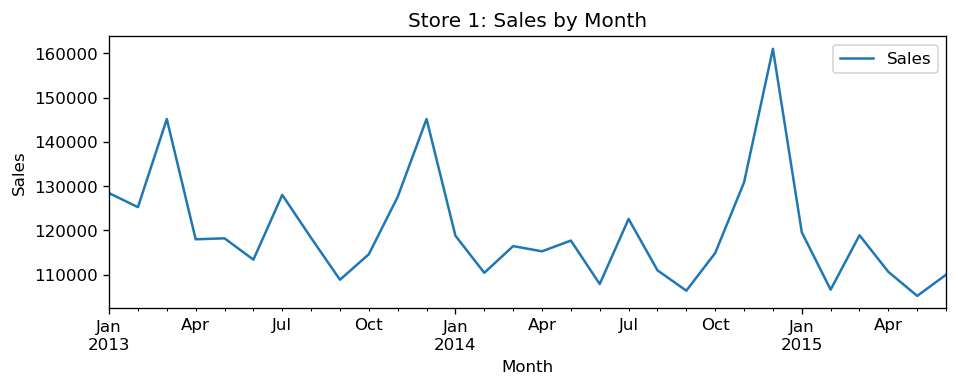

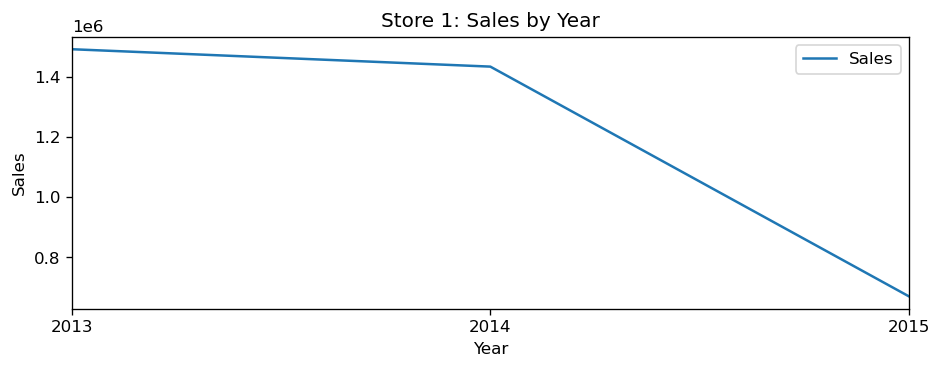

Initial observations show possible peaks in monthly sales around December during the holiday-season, as well as what might be smaller recurring peaks in March (Easter Sales on Winter/last season goods) and July (4th of July, Independence Day). However these seasonal peaks appear inconsistent in magnitude between each occurance. Alternatively, we observe a declining overal trend in annual sales.


In [332]:
# first of all, let's take a look at the general sales by month and year plots

# Create columns containing the month and year
# note: 'Date' is an index in our df, so we need to call .index.get_level_values('Date') 
# this pretty much functions the same as store1_train['Date'], if 'Date' were a regular column
store1_train['month'] = pd.to_datetime(store1_train.index.get_level_values('Date')).to_period('M')
store1_train['year'] = pd.to_datetime(store1_train.index.get_level_values('Date')).to_period('Y')

month_plot = store1_train.groupby(['month'])['Sales'].sum().plot(legend=True)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Store 1: Sales by Month')
plt.show() # need to add this part or both month and year plots appear in the same chart

year_plot = store1_train.groupby(['year'])['Sales'].sum().plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Store 1: Sales by Year')
plt.show()

print('Initial observations show possible peaks in monthly sales around December during the holiday-season, as well as what might be smaller recurring peaks in March (Easter Sales on Winter/last season goods) and July (4th of July, Independence Day). However these seasonal peaks appear inconsistent in magnitude between each occurance. Alternatively, we observe a declining overal trend in annual sales.')

In [262]:
store1_train.drop(['month', 'year'], axis=1, inplace=True)
store1_train

,Store,Sales,Open,DayOfWeek
Date,,,,
2013-01-01,1,0,0,2
2013-01-02,1,5530,1,3
2013-01-03,1,4327,1,4
2013-01-04,1,4486,1,5
2013-01-05,1,4997,1,6
...,...,...,...,...
2015-06-26,1,3317,1,5
2015-06-27,1,4019,1,6
2015-06-28,1,0,0,7


Monday=1, Sunday=7


,DayOfWeek,Sales
0,1,642870
1,2,610613
2,3,579321
3,4,530101
4,5,587422
5,6,645261
6,7,0


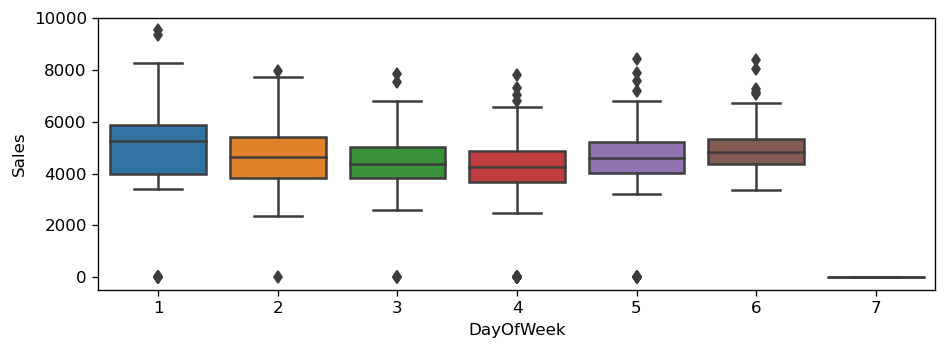

<Figure size 1800x960 with 0 Axes>

Observations:

1. On Sunday, stores are closed and thus Sales == 0
2. Sales on Monday and Saturday are the highest in total volume
3. Monday has the largest spread in sales magnitude (interquartile range), and Saturday the least
4. Outliers are present in all days (sans Sunday)
5. Holidays may cause store closures, and thus cause sales on any day to be 0 (as an outlier)
6. Outliers appear more frequently on Thu, Fri and Sat


In [333]:
# let's also take a quick look at daily sales with a boxplot
print('Monday=1, Sunday=7')

sns.boxplot(x = "DayOfWeek", y = "Sales", data = store1_train)
plt.figure(figsize=(15,8)) # set figure size

sales_by_day2 = store1_train.groupby(['DayOfWeek'])['Sales'].sum().reset_index()
display(sales_by_day2)

plt.show()

print('Observations:\n')
print('1. On Sunday, stores are closed and thus Sales == 0')
print('2. Sales on Monday and Saturday are the highest in total volume')
print('3. Monday has the largest spread in sales magnitude (interquartile range), and Saturday the least')
print('4. Outliers are present in all days (sans Sunday)')
print('5. Holidays may cause store closures, and thus cause sales on any day to be 0 (as an outlier)')
print('6. Outliers appear more frequently on Thu, Fri and Sat')

###### Observations by Seasonal Decomposition

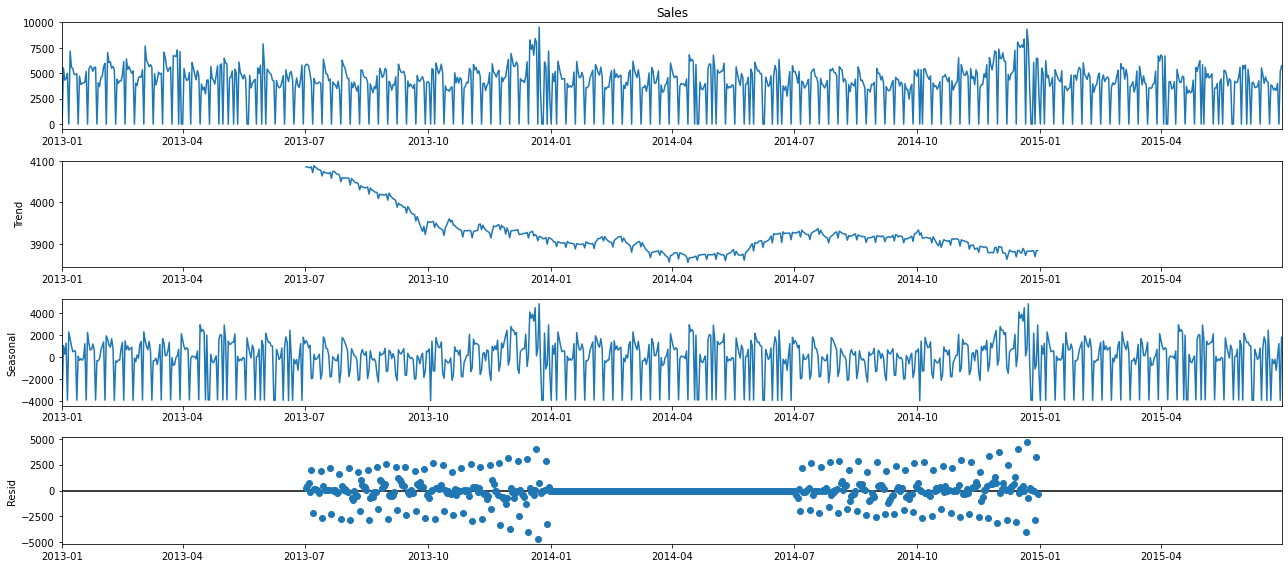

Observations:
1. The trend is indeed declining over the years
2. The clearest seasonal changes are during the December holiday sales
3. Residuals tend to occur in the 2nd half of the year, indicating variability in sales during this time between each year


In [264]:
# Automatic time-series seasonal decomposition using moving averages
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(store1_train['Sales'], model = 'additive', period = 365) #extrapolate_trend='freq' takes care of any missing values in the trend and residuals
decomposition.plot()
plt.show()

# In an Additive Model:
# observed = trend + seasonal + resid
# 1. trend is long-term change
# 2. seasonal is systematic change at a given time of year
# 3. resid is whatever that is otherwise unpredicted/unexpected

print('Observations:')
print('1. The trend is indeed declining over the years')
print('2. The clearest seasonal changes are during the December holiday sales')
print('3. Residuals tend to occur in the 2nd half of the year, indicating variability in sales during this time between each year')

# note: It tends to be better for values regarding money to be decomposed as 'multiplicative' rather than additive. 
# however decomposing with data that has 0 or negative values throws an error (not possible), though there may be 
# a library/function out there that can do this: https://stats.stackexchange.com/questions/454819/how-to-use-holt-winters-seasonal-multiplicative-method-when-the-data-has-zero-v
# additionally, when choosing between multi and additive, look at which has a more 'random' distribution of residuals
# the more random it is, the more appropriate the model type is (https://www.machinelearningplus.com/time-series/time-series-analysis-python/)

###### Test for Stationarity (order of differencing (d))

In [265]:
from statsmodels.tsa.stattools import adfuller, kpss

In [266]:
# let's definte a function that plots and runs two stationarity tests, along with a print statement for the results

# ADH:  Null hypothesis is that the time series has a unit root. Lack of a unit root implies stationarity
# -- if ADH Statistic is lower than significance level (critical value), reject the null hypothesis (thus is stationary)
# -- or if p-value is less than 5% (0.05), reject the null hypothesis (thus is stationary)

# KPSS: Null hypothesis is that the TREND of the time series is stationary
# -- if KPSS Statistic is lower than significance level (critical value), accept the null hypothesis (thus is stationary)
# -- or if p-value is more than 5% (0.05), accept the null hypothesis (thus is stationary)


def test_stationarity(timeseries):

    #Determine rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Augmented Dickey Fuller test (ADH Test)
    print('Results of Augmented Dickey-Fuller (ADH) Test:')
    ADH_test = adfuller(timeseries, autolag='AIC')
    ADH_output = pd.Series(ADH_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) #https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
#     print(f'ADF Statistic: {ADH_test[0]}')
#     print(f'p-value: {ADH_test[1]}')
    for key, value in ADH_test[4].items():
        ADH_output['Critical Value (%s)'%key] = value
    print(ADH_output)
    if ADH_test[0] < ADH_test[4]['5%'] or ADH_test[1] < 0.05:
        print('\033[1m' + 'ADH Test at 0.05 Significance level shows that this time series IS stationary'+ '\033[0;0m')
    else:
        print('\033[1m' + 'ADH Test at 0.05 Significance level shows that this time series IS NOT stationary'+ '\033[0;0m')
    
    print('\n')
    
    # Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationarity)
    KPSS_test = kpss(timeseries, regression='c')
    print('Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:')
    KPSS_output = pd.Series(KPSS_test[0:3], index=['Test Statistic','p-value','#Lags Used']) #https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
#     print(f'KPSS Statistic: {KPSS_test[0]}')
#     print(f'p-value: {KPSS_test[1]}')
    for key, value in KPSS_test[3].items():
        KPSS_output['Critical Value (%s)'%key] = value
    print(KPSS_output)
    if KPSS_test[0] > KPSS_test[3]['5%'] or KPSS_test[1] > 0.05:
        print('\033[1m' + 'KPSS Test at 0.05 Significance level shows that this time series IS stationary'+ '\033[0;0m')
    else:
        print('\033[1m' + 'KPSS Test at 0.05 Significance level shows that this time series IS NOT stationary'+ '\033[0;0m')

# NOTE: A proper if/else statement should also account for NaN values (failed tests), 
# and to create separate conditions for both p-value AND Test Statistics outcomes

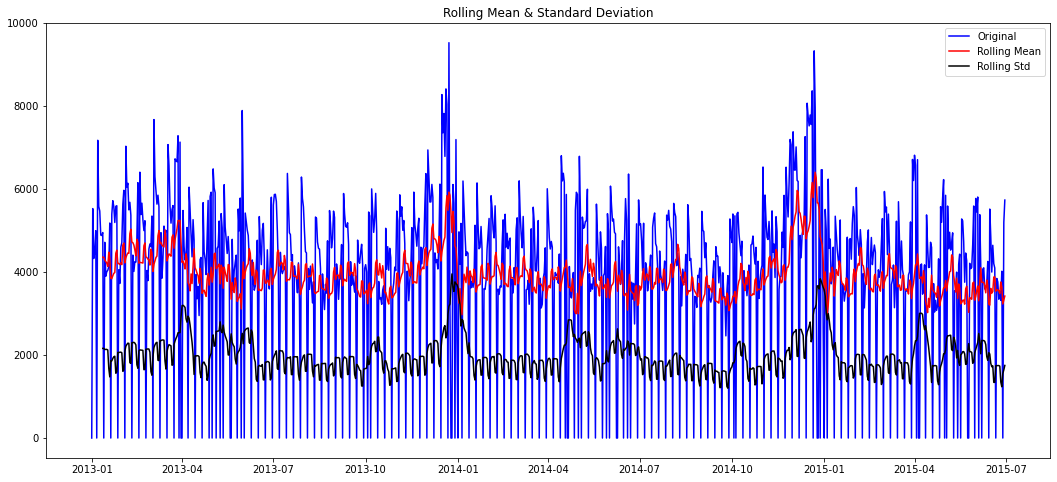

Results of Augmented Dickey-Fuller (ADH) Test:
Test Statistic                  -4.236942
p-value                          0.000570
#Lags Used                      21.000000
Number of Observations Used    889.000000
Critical Value (1%)             -3.437727
Critical Value (5%)             -2.864797
Critical Value (10%)            -2.568504
dtype: float64
ADH Test at 0.05 Significance level shows that this time series IS stationary


Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Test Statistic            0.300546
p-value                   0.100000
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS Test at 0.05 Significance level shows that this time series IS stationary


In [267]:
test_stationarity(store1_train['Sales'])

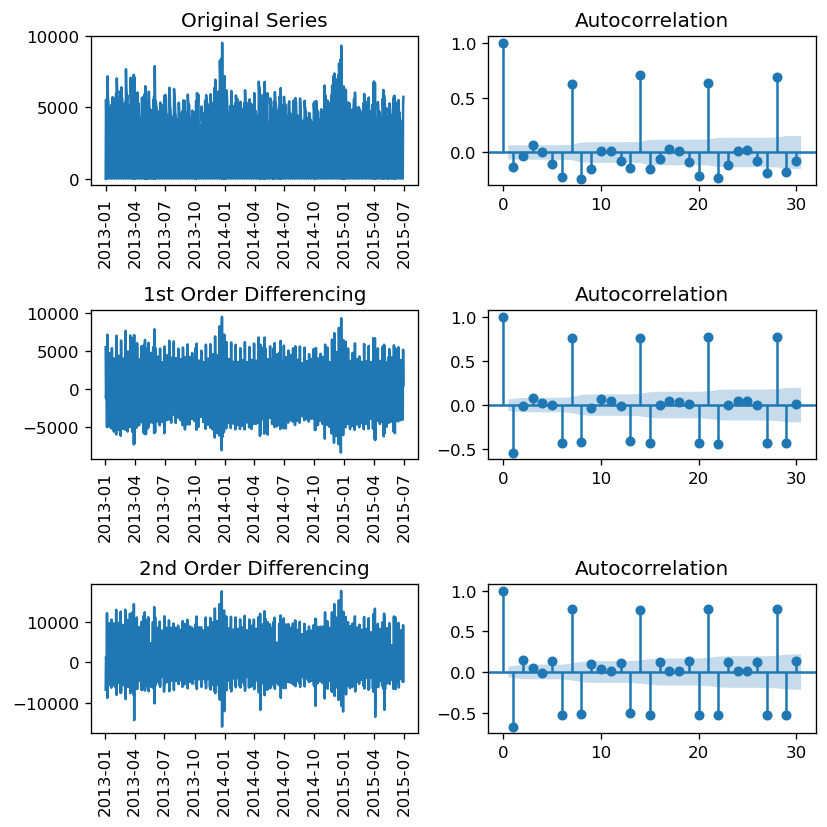

In [329]:
# The results of our tests indicate stationarity at a Sig.Level of 0.05
# However, differencing might still improve this result even further (strong stationarity vs. weak stationarity) 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(store1_train.Sales); axes[0, 0].set_title('Original Series')
plot_acf(store1_train.Sales, ax=axes[0, 1])
axes[0, 0].tick_params(axis='x', rotation=90)

# 1st Differencing
axes[1, 0].plot(store1_train.Sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(store1_train.Sales.diff().dropna(), ax=axes[1, 1])
axes[1, 0].tick_params(axis='x', rotation=90)

# 2nd Differencing
axes[2, 0].plot(store1_train.Sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(store1_train.Sales.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 0].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

#notes: The right order of differencing is the minimum differencing required to get a near-stationary series 
#which roams around a defined mean and the ACF plot reaches to zero fairly quick.
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [269]:
display(store1_train['Sales'])

Date
2013-01-01       0
2013-01-02    5530
2013-01-03    4327
2013-01-04    4486
2013-01-05    4997
              ... 
2015-06-26    3317
2015-06-27    4019
2015-06-28       0
2015-06-29    5197
2015-06-30    5735
Name: Sales, Length: 911, dtype: int64

The above results show that 1 Order of Differencing is sufficient to induce stationarity in the data. However, the autocorrelation plot for the 1st Order of Differencing goes into negative territory quickly, indicating the possibility 
of over-differencing. Thus we need not apply differencing at all for our dataset, OR we could try separate models for 0 order and 1 order of differencing each.

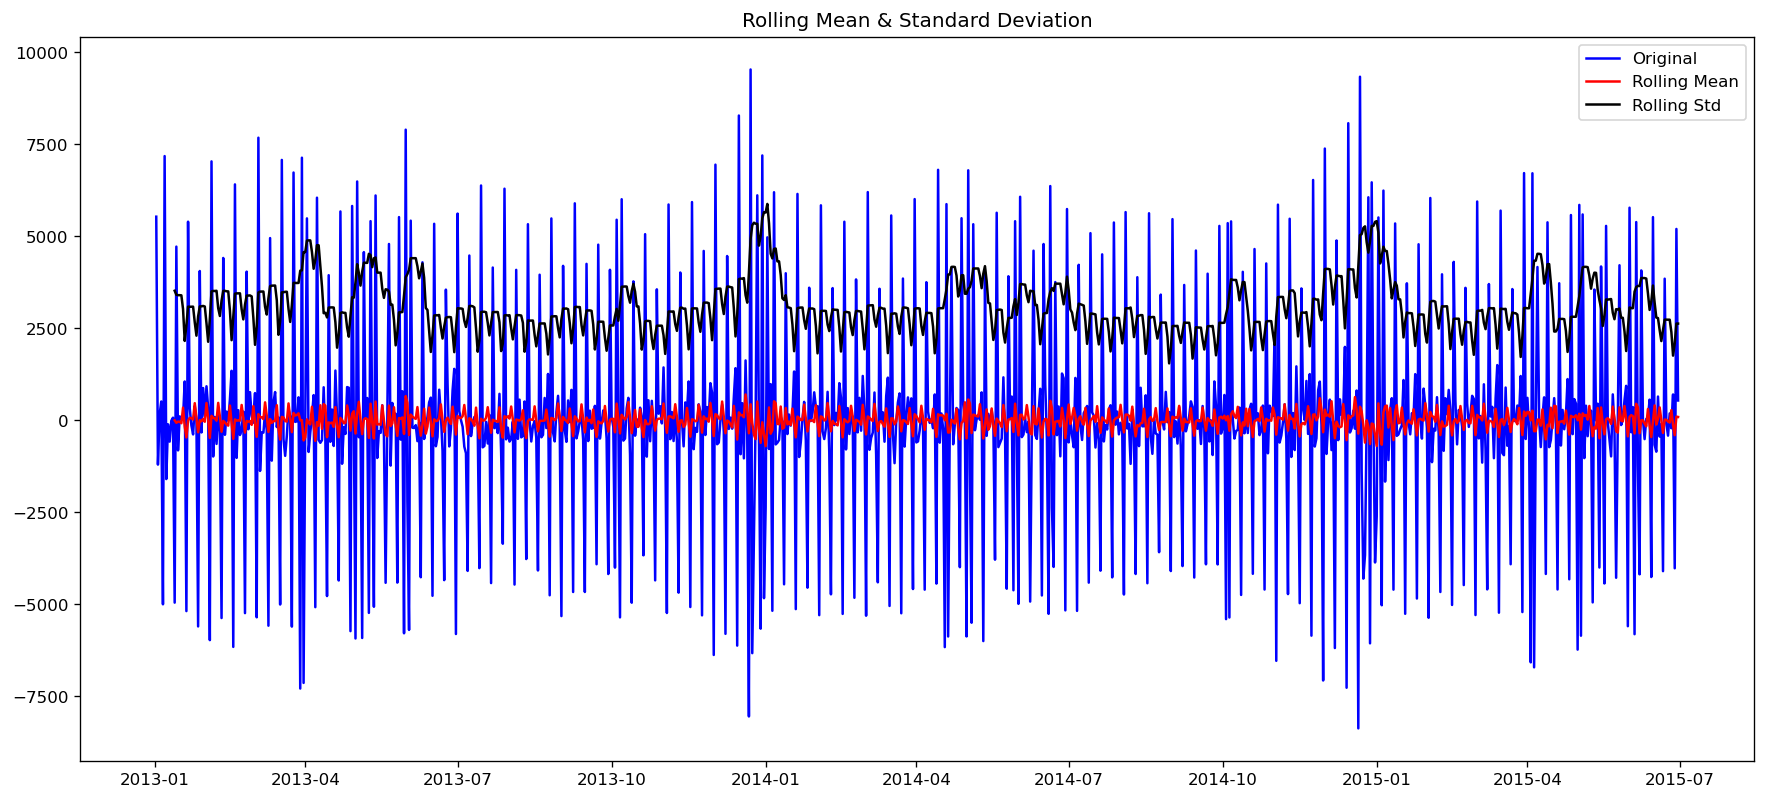

Results of Augmented Dickey-Fuller (ADH) Test:
Test Statistic                -1.134395e+01
p-value                        1.038132e-20
#Lags Used                     2.000000e+01
Number of Observations Used    8.890000e+02
Critical Value (1%)           -3.437727e+00
Critical Value (5%)           -2.864797e+00
Critical Value (10%)          -2.568504e+00
dtype: float64
ADH Test at 0.05 Significance level shows that this time series IS stationary


Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Test Statistic            0.019063
p-value                   0.100000
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS Test at 0.05 Significance level shows that this time series IS stationary


In [270]:
# create series to apply .diff and drop all NaN values
first_diff = store1_train['Sales']
first_diff = first_diff.diff().dropna(inplace = False)

# stationarity test of 1 order differencing. Note how the rolling mean has flattened from before
rcParams['figure.figsize'] = 18, 8
test_stationarity(first_diff)

###### Find the order of the AR term (p)

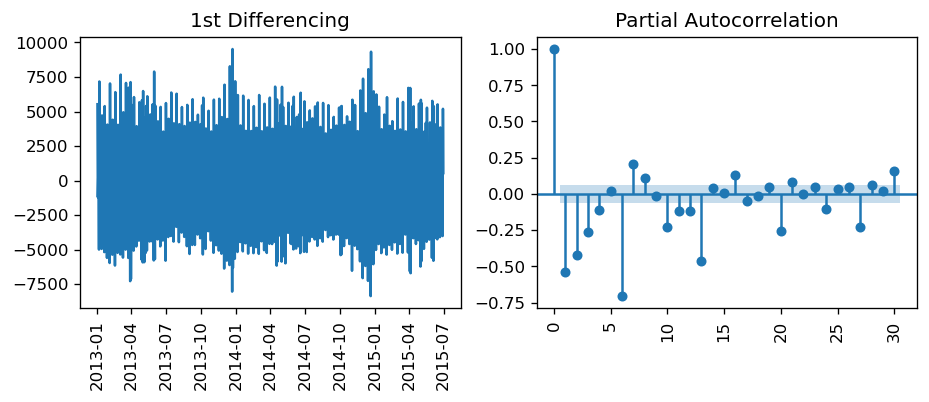

In [330]:
# Please ignore hashed lines. I initially encountered an axis-range issue that was there due to sharex=True
#===================================================================================================

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# I do not know why the data is defaulting to starting from 1970..but this is my attempt to fix it
# x_axis_min = datetime.datetime(2013, 1, 1)
# x_axis_max = datetime.datetime(2015, 6, 30)
# x_axis_min_pacf = datetime.datetime(1969, 12, 31)
# x_axis_max_pacf = datetime.datetime(1970, 2, 1)

# I am also not sure why the x-axis cannot be individually set here...
fig, (axes1, axes2) = plt.subplots(1, 2)
# differencing plot
axes1.plot(store1_train.Sales.diff())
axes1.set_title('1st Differencing')
# axes1.set_xlim(x_axis_min, x_axis_max) # when this is removed, the chart defaults as below
axes1.tick_params(axis='x', labelrotation=90)
# pacf plot
plot_pacf(store1_train.Sales.diff().dropna(), ax=axes2)
# axes2.set_xlim(x_axis_min_pacf, x_axis_max_pacf) # when this is removed, the chart defaults as below
# axes2.set_ylim((0,1.1))
axes2.tick_params(axis='x', labelrotation=90)

plt.show()

Based on the Partial Autocorrelation plot, the value for (p) can be initially set at 6, since we observe that there are 6 lags (blue dots) above the significance line ((blue area)

###### Find the order of the MA term (q)

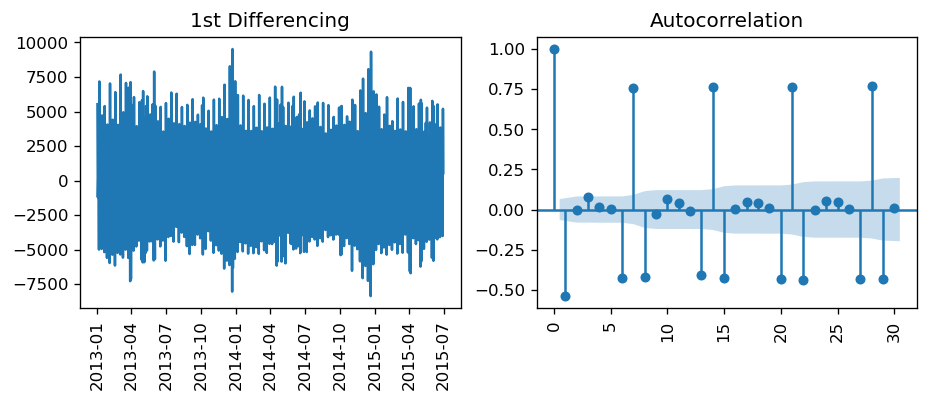

In [331]:
# Please ignore hashed lines. I initially encountered an axis-range issue that was there due to sharex=True
#===================================================================================================

# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# I do not know why the data is defaulting to starting from 1970..but this is my attempt to fix it
# x_axis_min = datetime.datetime(2013, 1, 1)
# x_axis_max = datetime.datetime(2015, 6, 30)
# x_axis_min_acf = datetime.datetime(1969, 12, 31)
# x_axis_max_acf = datetime.datetime(1970, 2, 1)

# I am also not sure why the x-axis cannot be individually set here...
fig, (axes1, axes2) = plt.subplots(1, 2)
# differencing plot
axes1.plot(store1_train.Sales.diff())
axes1.set_title('1st Differencing')
# axes1.set_xlim(x_axis_min, x_axis_max) # when this is removed, the chart defaults as below
axes1.tick_params(axis='x', labelrotation=90)
# acf plot
plot_acf(store1_train.Sales.diff().dropna(), ax=axes2)
# axes2.set_xlim(x_axis_min_acf, x_axis_max_acf) # when this is removed, the chart defaults as below
# axes2.set_ylim((0,1.1))
axes2.tick_params(axis='x', labelrotation=90)

plt.show()

Based on the Autocorrelation plot, the value for (q) can be initially set at 5, since we observe that there are 5 lags (blue dots) above the significance line ((blue area)

###### ARIMA with 0 order differencing and initial pqd settings

In [275]:
train_data = store1_train.copy()
display(train_data)
display(store1_test)

# ARIMA(p,d,q)
# p = 6
# d = 0
# q = 5

,Store,Sales,Open,DayOfWeek
Date,,,,
2013-01-01,1,0,0,2
2013-01-02,1,5530,1,3
2013-01-03,1,4327,1,4
2013-01-04,1,4486,1,5
2013-01-05,1,4997,1,6
...,...,...,...,...
2015-06-26,1,3317,1,5
2015-06-27,1,4019,1,6
2015-06-28,1,0,0,7


,Store,Sales,Open,DayOfWeek
Date,,,,
2015-07-01,1,5223,1,3
2015-07-02,1,5558,1,4
2015-07-03,1,4665,1,5
2015-07-04,1,4797,1,6
2015-07-05,1,0,0,7
2015-07-06,1,4359,1,1
2015-07-07,1,3650,1,2
2015-07-08,1,3797,1,3
2015-07-09,1,3897,1,4


In [276]:
#Auto Regressive (AR) model
ar_mod = ARIMA(train_data.Sales, (6,0,0), freq='D')
res_AR0 = ar_mod.fit(disp=False)
Y_pred_AR0 = res_AR0.forecast(steps=31)[0]

# evaluate
Model_AR0_RMSE = np.sqrt(mean_squared_error(Y_pred_AR0, store1_test.Sales))
Model_AR0_MAPE = (mean_absolute_percentage_error(Y_pred_AR0, store1_test.Sales)*100)

print('Model AR0 RMSE %0.3f' %Model_AR0_RMSE)
print('Model AR0 MAPE %0.3f%%' %Model_AR0_MAPE)

Model AR0 RMSE 1583.151
Model AR0 MAPE 28.429%


In [277]:
#Moving Average (MA) model
ma_mod = ARIMA(train_data.Sales, (0,0,5), freq='D')
res_MA0 = ma_mod.fit(disp=False)
Y_pred_MA0 = res_MA0.forecast(steps=31)[0]

# evaluate
Model_MA0_RMSE = np.sqrt(mean_squared_error(Y_pred_MA0, store1_test.Sales))
Model_MA0_MAPE = (mean_absolute_percentage_error(Y_pred_MA0, store1_test.Sales)*100)

print('Model MA0 RMSE %0.3f' %Model_MA0_RMSE)
print('Model MA0 MAPE %0.3f%%' %Model_MA0_MAPE)

Model MA0 RMSE 1658.279
Model MA0 MAPE 29.794%


In [278]:
#Autoregressive Integrated Moving Average (ARIMA) model
arima_mod = ARIMA(train_data.Sales, (6,0,5), freq='D')
res_ARIMA0 = arima_mod.fit(disp=False)
Y_pred_ARIMA0 = res_ARIMA0.forecast(steps=31)[0]

# evaluate
Model_ARIMA0_RMSE = np.sqrt(mean_squared_error(Y_pred_ARIMA0, store1_test.Sales))
Model_ARIMA0_MAPE = (mean_absolute_percentage_error(Y_pred_ARIMA0, store1_test.Sales)*100)

print('Model ARIMA0 RMSE %0.3f' %Model_ARIMA0_RMSE)
print('Model ARIMA0 MAPE %0.3f%%' %Model_ARIMA0_MAPE)

Model ARIMA0 RMSE 1104.393
Model ARIMA0 MAPE 34.414%


###### ARIMA with 1 order differencing and initial pqd settings

In [279]:
train_data = store1_train.copy()
display(train_data)
display(store1_test)

# ARIMA(p,d,q)
# p = 6
# d = 1
# q = 5

,Store,Sales,Open,DayOfWeek
Date,,,,
2013-01-01,1,0,0,2
2013-01-02,1,5530,1,3
2013-01-03,1,4327,1,4
2013-01-04,1,4486,1,5
2013-01-05,1,4997,1,6
...,...,...,...,...
2015-06-26,1,3317,1,5
2015-06-27,1,4019,1,6
2015-06-28,1,0,0,7


,Store,Sales,Open,DayOfWeek
Date,,,,
2015-07-01,1,5223,1,3
2015-07-02,1,5558,1,4
2015-07-03,1,4665,1,5
2015-07-04,1,4797,1,6
2015-07-05,1,0,0,7
2015-07-06,1,4359,1,1
2015-07-07,1,3650,1,2
2015-07-08,1,3797,1,3
2015-07-09,1,3897,1,4


In [280]:
#Auto Regressive (AR) model
ar_mod = ARIMA(train_data.Sales, (6,1,0), freq='D')
res_AR1 = ar_mod.fit(disp=False)
Y_pred_AR1 = res_AR1.forecast(steps=31)[0]

# evaluate
Model_AR1_RMSE = np.sqrt(mean_squared_error(Y_pred_AR1, store1_test.Sales))
Model_AR1_MAPE = (mean_absolute_percentage_error(Y_pred_AR1, store1_test.Sales)*100)

print('Model AR1 RMSE %0.3f' %Model_AR1_RMSE)
print('Model AR1 MAPE %0.3f%%' %Model_AR1_MAPE)

Model AR1 RMSE 1204.440
Model AR1 MAPE 31.097%


In [281]:
#Moving Average (MA) model
ma_mod = ARIMA(train_data.Sales, (0,1,5), freq='D')
res_MA1 = ma_mod.fit(disp=False)
Y_pred_MA1 = res_MA1.forecast(steps=31)[0]

# evaluate
Model_MA1_RMSE = np.sqrt(mean_squared_error(Y_pred_MA1, store1_test.Sales))
Model_MA1_MAPE = (mean_absolute_percentage_error(Y_pred_MA1, store1_test.Sales)*100)

print('Model MA1 RMSE %0.3f' %Model_MA1_RMSE)
print('Model MA1 MAPE %0.3f%%' %Model_MA1_MAPE)

Model MA1 RMSE 1732.677
Model MA1 MAPE 39.647%


In [282]:
#Autoregressive Integrated Moving Average (ARIMA) model
arima_mod = ARIMA(train_data.Sales, (6,1,5), freq='D')
res_ARIMA1 = arima_mod.fit(disp=False)
Y_pred_ARIMA1 = res_ARIMA1.forecast(steps=31)[0]

# evaluate
Model_ARIMA1_RMSE = np.sqrt(mean_squared_error(Y_pred_ARIMA1, store1_test.Sales))
Model_ARIMA1_MAPE = (mean_absolute_percentage_error(Y_pred_ARIMA1, store1_test.Sales)*100)

print('Model ARIMA1 RMSE %0.3f' %Model_ARIMA1_RMSE)
print('Model ARIMA1 MAPE %0.3f%%' %Model_ARIMA1_MAPE)

Model ARIMA1 RMSE 1137.095
Model ARIMA1 MAPE 35.822%


###### ARIMA with 1 order differencing and MAXIMIZED pqd settings

In [283]:
train_data = store1_train.copy()
display(train_data)
display(store1_test)

# ARIMA(p,d,q)
# now based on trial and error

,Store,Sales,Open,DayOfWeek
Date,,,,
2013-01-01,1,0,0,2
2013-01-02,1,5530,1,3
2013-01-03,1,4327,1,4
2013-01-04,1,4486,1,5
2013-01-05,1,4997,1,6
...,...,...,...,...
2015-06-26,1,3317,1,5
2015-06-27,1,4019,1,6
2015-06-28,1,0,0,7


,Store,Sales,Open,DayOfWeek
Date,,,,
2015-07-01,1,5223,1,3
2015-07-02,1,5558,1,4
2015-07-03,1,4665,1,5
2015-07-04,1,4797,1,6
2015-07-05,1,0,0,7
2015-07-06,1,4359,1,1
2015-07-07,1,3650,1,2
2015-07-08,1,3797,1,3
2015-07-09,1,3897,1,4


In [284]:
#Auto Regressive (AR) model
ar_mod = ARIMA(train_data.Sales, (9,1,0), freq='D')
res_AR2 = ar_mod.fit(disp=False)
Y_pred_AR2 = res_AR2.forecast(steps=31)[0]

# evaluate
Model_AR2_RMSE = np.sqrt(mean_squared_error(Y_pred_AR2, store1_test.Sales))
Model_AR2_MAPE = (mean_absolute_percentage_error(Y_pred_AR2, store1_test.Sales)*100)

print('Model AR2 RMSE %0.3f' %Model_AR2_RMSE)
print('Model AR2 MAPE %0.3f%%' %Model_AR2_MAPE)

Model AR2 RMSE 1133.857
Model AR2 MAPE 28.733%


In [285]:
#Moving Average (MA) model
ma_mod = ARIMA(train_data.Sales, (0,1,1), freq='D')
res_MA2 = ma_mod.fit(disp=False)
Y_pred_MA2 = res_MA2.forecast(steps=31)[0]

# evaluate
Model_MA2_RMSE = np.sqrt(mean_squared_error(Y_pred_MA2, store1_test.Sales))
Model_MA2_MAPE = (mean_absolute_percentage_error(Y_pred_MA2, store1_test.Sales)*100)

print('Model MA2 RMSE %0.3f' %Model_MA2_RMSE)
print('Model MA2 MAPE %0.3f%%' %Model_MA2_MAPE)

Model MA2 RMSE 1642.083
Model MA2 MAPE 31.530%


In [286]:
#Autoregressive Integrated Moving Average (ARIMA) model
arima_mod = ARIMA(train_data.Sales, (9,1,9), freq='D')
res_ARIMA2 = arima_mod.fit(disp=False)
Y_pred_ARIMA2 = res_ARIMA2.forecast(steps=31)[0]

# evaluate
Model_ARIMA2_RMSE = np.sqrt(mean_squared_error(Y_pred_ARIMA2, store1_test.Sales))
Model_ARIMA2_MAPE = (mean_absolute_percentage_error(Y_pred_ARIMA2, store1_test.Sales)*100)

print('Model ARIMA2 RMSE %0.3f' %Model_ARIMA2_RMSE)
print('Model ARIMA2 MAPE %0.3f%%' %Model_ARIMA2_MAPE)

Model ARIMA2 RMSE 615.743
Model ARIMA2 MAPE 23.172%


#### Results

In [319]:
# Load our previous modelling results
%store -r Results_All_Models_data

In [320]:
print("Our best time-series model with ARIMA indicates the best performing RMSE score, although Model_4_Ridge continues have the best performing MAPE score)\n")

temp5 = pd.DataFrame({
    "Model":          ['Model AR0',       'Model MA0',       'Model ARIMA0',       'Model AR1' ,       'Model MA1' ,       'Model ARIMA1',       'Model AR2',       'Model MA2',      'Model ARIMA2'],
    "RMSE Score":     [ Model_AR0_RMSE,    Model_MA0_RMSE,    Model_ARIMA0_RMSE,    Model_AR1_RMSE ,    Model_MA1_RMSE ,    Model_ARIMA1_RMSE,    Model_AR2_RMSE,    Model_MA2_RMSE,   Model_ARIMA2_RMSE],
    "MAPE Score (%)": [ Model_AR0_MAPE,    Model_MA0_MAPE,    Model_ARIMA0_MAPE,    Model_AR1_MAPE ,    Model_MA1_MAPE ,    Model_ARIMA1_MAPE,    Model_AR2_MAPE,    Model_MA2_MAPE,   Model_ARIMA2_MAPE]})

temp5['RMSE Score'] = temp5['RMSE Score'].map('{:,.2f}'.format)
temp5['MAPE Score (%)'] = temp5['MAPE Score (%)'].map('{:,.2f}%'.format)

Results_All_Models_data = Results_All_Models_data.append(temp5, ignore_index = True)
display(Results_All_Models_data)

print("Note: Model RFR2 and XGBR3 have 0 values as they could not be processed within a normal amount of time due to limitations in hardware/insufficient time. In any case, they would not have likely had better RMSE and MAPE scores than the linear models")

Our best time-series model with ARIMA indicates the best performing RMSE score, although Model_4_Ridge continues have the best performing MAPE score)



,Model,RMSE Score,MAPE Score (%)
0,Model_1,"1,427.78",25.54%
1,Model_2,958.59,21.67%
2,Avg_Ensemble (0 & 1),"1,044.47",22.65%
3,Model_1_Ridge,"1,431.52",25.59%
4,Model_2_Ridge,943.77,21.44%
5,Model_2_Bagging,"1,224.31",10.28%
6,Avg_Ensemble_2 (1 & 4),937.91,21.45%
7,Avg_Ensemble_3 (4 & 5),981.58,21.51%
8,Model_3,"1,229.92",13.60%
9,Model_4,"1,014.80",9.56%


Note: Model RFR2 and XGBR3 have 0 values as they could not be processed within a normal amount of time due to limitations in hardware/insufficient time. In any case, they would not have likely had better RMSE and MAPE scores than the linear models


## Unfortunately, given time constraints (2-week timeline given for 4 weeks of Project Tasks), the following two sections were not able to be fully developed in accordance with recommended steps

**Project Task: Week 3**

**Implementing Neural Networks:**

1. Train a LSTM on the same set of features and compare the result with traditional time-series model.
2. Comment on the behavior of all the models you have built so far
3. Cluster stores using sales and customer visits as features. Find out how many clusters or groups are possible. Also visualize the results.
4. Is it possible to have separate prediction models for each cluster? Compare results with the previous models.

#### LSTM for store1

In [298]:
# returns an array of shape (911,1)
train_store1 = store1_train.iloc[:, 1:2].values

# scaling each feature to a given range
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_store1 = sc.fit_transform(train_store1)

# defining x and y trains
X_train = []
Y_train = []
for i in range(30, 911):
    X_train.append(train_store1[i-30:i, 0])
    Y_train.append(train_store1[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [305]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# LSTM model
regressor = Sequential()
regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(LSTM(units = 70, return_sequences = True))
regressor.add(LSTM(units = 50))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, Y_train, epochs = 100, batch_size = 64, shuffle=False)

Epoch 1/100
14/14 [==============================] - 8s 17ms/step - loss: 0.0882
Epoch 2/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0485
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0454
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0450
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0450
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0450
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0450
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0450
Epoch 9/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0450
Epoch 10/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0450
Epoch 11/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0450
Epoch 12/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0450
Epoch 13/100
14/14 [=====

In [306]:
total_data = pd.concat((store1_train['Sales'], store1_test['Sales']), axis = 0)
inputs = total_data[len(total_data) - len(store1_test) - 30:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(30, 61):
    X_test.append(inputs[i-30:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred = regressor.predict(X_test)
pred= sc.inverse_transform(pred)

# evaluate
Model_LSTM_RMSE = np.sqrt(mean_squared_error(pred, store1_test.Sales))
Model_LSTM_MAPE = (mean_absolute_percentage_error(pred, store1_test.Sales)*100)

print('Model LSTM RMSE %0.3f' %Model_LSTM_RMSE)
print('Model LSTM MAPE %0.3f%%' %Model_LSTM_MAPE)

Model LSTM RMSE 1537.430
Model LSTM MAPE 29.280%


**Project Task: Week 4**

**Applying ANN:**

1.     Use ANN (Artificial Neural Network) to predict Store Sales.
       1.    Fine-tune number of layers,
       2.    Number of Neurons in each layers .
       3.    Experiment in batch-size.
       4.    Experiment with number of epochs. Carefully observe the loss and accuracy? What are the observations?
       5.    Play with different  Learning Rate  variants of Gradient Descent like Adam, SGD, RMS-prop.
       6.    Which activation performs best for this use case and why?
       7.    Check how it performed in the dataset, calculate RMSE.
2.    Use Dropout for ANN and find the optimum number of clusters (clusters formed considering the features: sales and customer
       visits). Compare model performance with traditional ML based prediction models. 
3.    Find the best setting of neural net that minimizes the loss and can predict the sales best. Use techniques like Grid
       search, cross-validation and Random search.

#### ANN

In [309]:
# Rebuild datasets
# This way is faster and less memory consumption than importing saved csv

train = pd.read_csv\
(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\train_data.csv")

test = pd.read_csv\
(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\test_data.csv")

test_val = pd.read_csv\
(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\test_data_hidden.csv")

test['Date'] = pd.to_datetime(test['Date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')

length_train = len(train.index)
length_test = len(test.index)
length_test_val = len(test_val.index)

combi = train.append(test, ignore_index=True)
combi = combi.append(test_val , ignore_index=True)

# Creating dummy variables for dates
combi['year'] = pd.to_datetime(combi['Date'],format='%Y-%m-%d').dt.year 
combi['month'] = pd.to_datetime(combi['Date'],format='%Y-%m-%d').dt.month 
combi['day'] = pd.to_datetime(combi['Date'],format='%Y-%m-%d').dt.day
combi['year'] = combi.year.replace({2013 : 0, 2014 : 1 , 2015 : 2 })  # replace year with discrete values
# It was noted that test data Dates format was initially flipped as format='%d-%m-%Y'. This was corrected to '%Y-%m-%d' earlier duing EDA.

# # Creating a new timedelta column
# combi['date_delta'] = pd.to_datetime(combi['Date'], format='%Y-%m-%d')
# combi['date_delta'] = ((combi['date_delta']-combi['date_delta'].min())/np.timedelta64(1,'D')) + 1

# Finally, we also address the StateHoliday variable by converting it from object/string to discrete values
combi['StateHoliday'] = combi.StateHoliday.replace({'0' : 0, 'a' : 1 , 'b' : 2 ,'c' : 3})

# Train a single model for all stores, using storeId as a feature.
combi1 = pd.get_dummies(combi, columns=['Store','DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday','year','month','day'],drop_first=True)
display(combi1.head())

# Train separate model for each store.
combi2 = pd.get_dummies(combi, columns=['DayOfWeek','Open', 'Promo','StateHoliday','SchoolHoliday','year','month','day'],drop_first=True)
display(combi2.head())

train1 = combi1.iloc[:length_train].reset_index(drop=True)
test1 = combi1.iloc[length_train:(length_train+length_test)].reset_index(drop=True)
test_val1 = combi1.iloc[(length_train+length_test):].reset_index(drop=True)

train2 = combi2.iloc[:length_train].reset_index(drop=True)
test2 = combi2.iloc[length_train:(length_train+length_test)].reset_index(drop=True)
test_val2 = combi2.iloc[(length_train+length_test):].reset_index(drop=True)

,Date,Sales,Customers,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,2015-06-30,5735.0,568,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2015-06-30,9863.0,877,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2015-06-30,13261.0,1072,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2015-06-30,13106.0,1488,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2015-06-30,6635.0,645,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


,Store,Date,Sales,Customers,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,1,2015-06-30,5735.0,568,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,2015-06-30,9863.0,877,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,2015-06-30,13261.0,1072,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,2015-06-30,13106.0,1488,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,2015-06-30,6635.0,645,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [310]:
%%time

# Model1
X_train = train2.drop(['Sales','Date','Customers'],axis=1).values
X_val = test_val2.drop(['Sales','Date','Customers'],axis=1).values
Y_train = pd.DataFrame(train2['Sales'])
Y_val = test_val2['Sales']

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
Y_train = sc.fit_transform(Y_train)

# ANN 1
model = Sequential()
model.add(Dense(100, activation='relu', input_dim = X_train.shape[1]))
#model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1,activation='linear',kernel_initializer='normal') )
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=10, batch_size=64,shuffle=False,verbose=0)

Y_pred = model.predict(X_val, batch_size=64,verbose=0)
Y_pred= sc.inverse_transform(Y_pred)

# evaluate
Model_ANN1_RMSE = np.sqrt(mean_squared_error(Y_pred,Y_val))
Model_ANN1_MAPE = (mean_absolute_percentage_error(Y_pred,Y_val)*100)

print('Model ANN1 RMSE %0.3f' %Model_ANN1_RMSE)
print('Model ANN1 MAPE %0.3f%%' %Model_ANN1_MAPE)

Model ANN1 RMSE 2647.929
Model ANN1 MAPE 37.657%
Wall time: 5min 37s


In [311]:
%%time

# Model2
X_train = train1.drop(['Sales','Date','Customers'],axis=1).values
X_val = test_val1.drop(['Sales','Date','Customers'],axis=1).values
Y_train = pd.DataFrame(train1['Sales'])
Y_val = test_val1['Sales']

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
Y_train = sc.fit_transform(Y_train)

#ANN 2
model = Sequential()
model.add(Dense(100, activation='relu', input_dim = X_train.shape[1]))
#model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear') )
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=10, batch_size=64,shuffle=False,verbose=0)

Y_pred = model.predict(X_val, batch_size=64,verbose=0)
Y_pred= sc.inverse_transform(Y_pred)

# evaluate
Model_ANN2_RMSE = np.sqrt(mean_squared_error(Y_pred,Y_val))
Model_ANN2_MAPE = (mean_absolute_percentage_error(Y_pred,Y_val)*100)

print('Model ANN2 RMSE %0.3f' %Model_ANN2_RMSE)
print('Model ANN2 MAPE %0.3f%%' %Model_ANN2_MAPE)

Model ANN2 RMSE 1541.394
Model ANN2 MAPE 31.986%
Wall time: 5min 47s


In [321]:
print("Our time-series model with ARIMA2 indicates the best performing RMSE score, although Model_4_Ridge continues have the best performing MAPE score)\n")

temp6 = pd.DataFrame({
    "Model":          ['Model LSTM',       'Model ANN1',       'Model ANN2',       ],
    "RMSE Score":     [ Model_LSTM_RMSE,    Model_ANN1_RMSE,    Model_ANN2_RMSE,   ],
    "MAPE Score (%)": [ Model_LSTM_MAPE,    Model_ANN1_MAPE,    Model_ANN2_MAPE,   ]})

temp6['RMSE Score'] = temp6['RMSE Score'].map('{:,.2f}'.format)
temp6['MAPE Score (%)'] = temp6['MAPE Score (%)'].map('{:,.2f}%'.format)

Results_All_Models_data = Results_All_Models_data.append(temp6, ignore_index = True)
display(Results_All_Models_data)

print("Note: Model RFR2 and XGBR3 have 0 values as they could not be processed within a normal amount of time due to limitations in hardware/insufficient time. In any case, they would not have likely had better RMSE and MAPE scores than the linear models")

Our time-series model with ARIMA2 indicates the best performing RMSE score, although Model_4_Ridge continues have the best performing MAPE score)



,Model,RMSE Score,MAPE Score (%)
0,Model_1,"1,427.78",25.54%
1,Model_2,958.59,21.67%
2,Avg_Ensemble (0 & 1),"1,044.47",22.65%
3,Model_1_Ridge,"1,431.52",25.59%
4,Model_2_Ridge,943.77,21.44%
5,Model_2_Bagging,"1,224.31",10.28%
6,Avg_Ensemble_2 (1 & 4),937.91,21.45%
7,Avg_Ensemble_3 (4 & 5),981.58,21.51%
8,Model_3,"1,229.92",13.60%
9,Model_4,"1,014.80",9.56%


Note: Model RFR2 and XGBR3 have 0 values as they could not be processed within a normal amount of time due to limitations in hardware/insufficient time. In any case, they would not have likely had better RMSE and MAPE scores than the linear models


Based on our interpretations of RMSE and MAPE scores in Part 2 of this assessment, MAPE scores are prefferred for comparisons of model performance between various models, particularly if the data used across these models are also different. Throughout our linear, non-linear and deep learning models, we have begun with the same dataset, but have transformed them in various ways based on the exploration of by-store level or all-store level cases. MAPE scores are percentage errors that vary between 0 and 1. Thus by using MAPE, we can judge how good a forecast/model is, irrespective of the scale of the series.

**Given this, our best performing model based on MAPE is Model_4_Ridge, with a score of 9.02%. This indicates that error residuals are only ~9%, or conversely, that the model performs with 90.98% accuracy.**

========================

Alternatively, our model ARIMA2 provided the best RMSE score, and could still serve as a useful model for forecasting sales into future timeperiods, particularly given seasonal and trend variations in sales over certain periods of the year (holiday sales, etc). Nonetheless, we will continue with MAPE as the determining score. An RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts/predictions of two differently scaled data.

In [322]:
# left this out as the sorting wasn't perfect.
#=====================================================
# # !pip install natsort
# import natsort as ns

# Results_All_Models_data['MAPE Score (%)'] = pd.Categorical(Results_All_Models_data['MAPE Score (%)'], ordered=True, 
#                                               categories= ns.natsorted(Results_All_Models_data['MAPE Score (%)'].unique()))
# Results_All_Models_data = Results_All_Models_data.sort_values('MAPE Score (%)')

# Results_All_Models_data